# Single-Shot CNN Denoising

We demonstrate that a deep neural net can be trained to denoise a _single_ noisy image, taking advantage of the fact that one 512 x 512 image contains ~250,000 dimensions of information.

In [249]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %gui qt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [250]:
import sys
sys.path.append("..")

In [251]:
from util import show, plot_images, plot_tensors

In [252]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk
from skimage.filters import gaussian, median
from skimage import data, img_as_float, img_as_ubyte
from skimage.color import gray2rgb
from skimage.util import random_noise
from skimage.measure import compare_psnr

In [253]:
from skimage.io import imread, imsave

In [254]:
plt.rc('figure', figsize = (5,5))

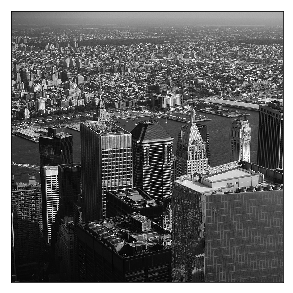

In [255]:
image = imread('/Users/josh/Desktop/NewYork.png')
show(image)

In [256]:
image = image[512 - 128:512+128, 512 - 128:512+128]

In [257]:
# import napari
# viewer = napari.view_image(image)

In [258]:
torch.permute?

Object `torch.permute` not found.


In [259]:
def split_tiles(x, tile_width):
    batch, channel, width, height = x.shape
    n_tiles = (width//tile_width)*(height//tile_width)
    return (torch.nn.Unfold(tile_width, stride=tile_width)(x)
            .permute(2, 0, 1)
            .reshape([n_tiles, 1, tile_width, tile_width]))

def merge_tiles(x, tile_width):
    batch, channel, tile_width, tile_height = x.shape
    n_tiles = (width//tile_width)*(height//tile_width)
    return (torch.nn.Unfold(tile_width, stride=tile_width)(x)
            .permute(2, 0, 1)
            .reshape([n_tiles, 1, tile_width, tile_width]))

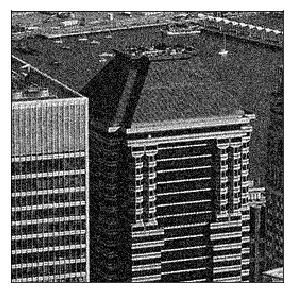

In [260]:
np.random.seed(3)
noisy_image = random_noise(image, mode = 'gaussian', var=0.01)
noisy_image2 = random_noise(image, mode = 'gaussian', var=0.01)
show(noisy_image)

In [261]:
imsave('~/Desktop/NoisyNewYork.png', np.clip(noisy_image, 0, 1))

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [262]:
# viewer.add_image(noisy_image)
# viewer.add_image(noisy_image2)

In [263]:
import torch
noisy = torch.Tensor(noisy_image[np.newaxis, np.newaxis])
clean = torch.Tensor(img_as_float(image)[np.newaxis, np.newaxis])
noisy2 = torch.Tensor(noisy_image2[np.newaxis, np.newaxis])

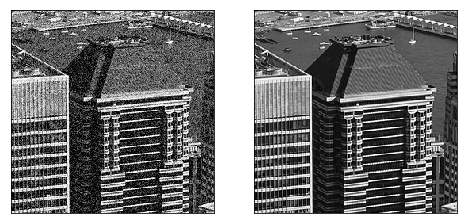

In [264]:
plot_tensors([noisy, clean])

In [265]:
clean = split_tiles(clean, 32)
noisy = split_tiles(noisy, 32)

In [266]:
noisy.shape

torch.Size([64, 1, 32, 32])

In [267]:
building_idx = [12, 13, 19, 20, 21, 22]
nonbuilding_idx = [x for x in range(len(clean)) if x not in building_idx]

In [268]:
clean = torch.index_select(clean, 0, torch.tensor(nonbuilding_idx))
noisy = torch.index_select(noisy, 0, torch.tensor(nonbuilding_idx))

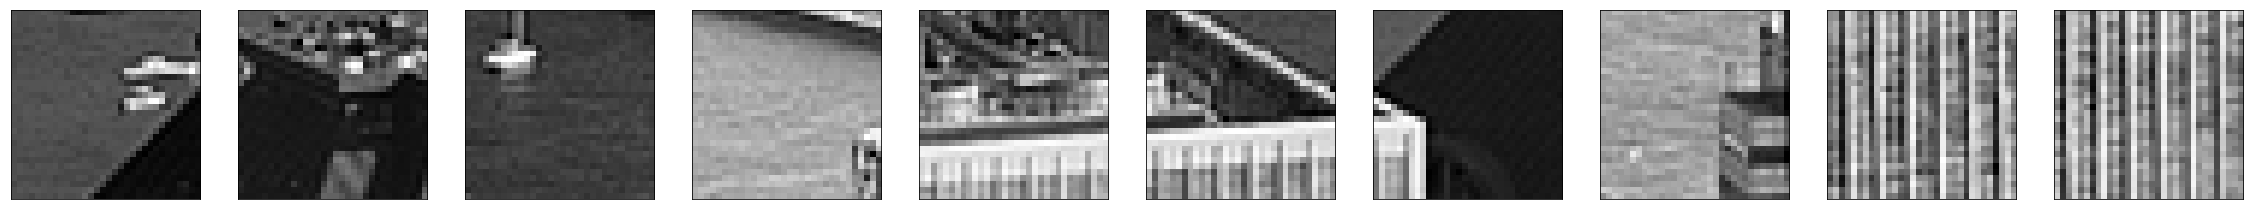

In [269]:
plot_tensors(clean[10:20])

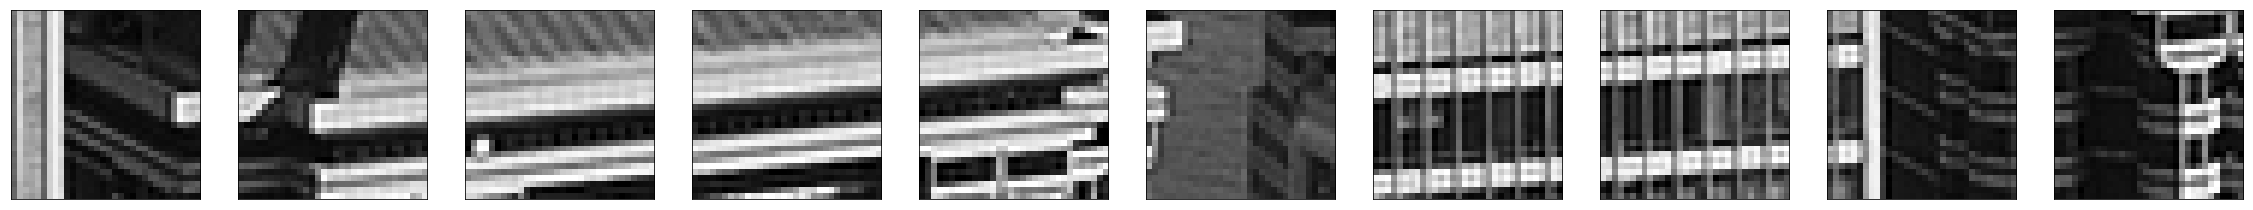

In [270]:
plot_tensors(clean[20:30])

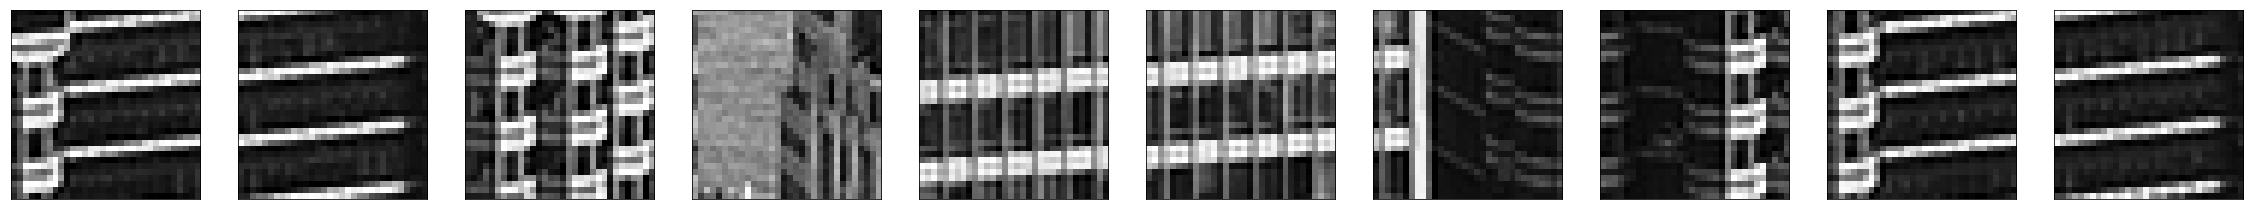

In [271]:
plot_tensors(clean[30:40])

In [272]:
from util import getbestgpu
#device = getbestgpu()

# Model

For our model, we use a short UNet with two levels of up- and down- sampling

In [302]:
from models.babyunet import BabyUnet
from models.unet import Unet
from models.dncnn import DnCNN, DnCNNKernel, ResCNN

from models.kernelpredicting import KernelPredicting

model = DnCNN(1, 1, 6)
# model = ResCNN(1, 32, 8)
model = KernelPredicting(1, DnCNN, kernel_width=15,
                         depth= 6,
                          features= 32)

In [291]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

102208

In [292]:
image.ravel().shape

(65536,)

# Training

In [293]:
from torch.nn import MSELoss, L1Loss
from torch.optim import Adam

loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)

In [294]:
noisy.shape

torch.Size([58, 1, 32, 32])

In [295]:
# model = model.to(device)
# noisy = noisy.to(device)

In [296]:
losses = []
val_losses = []
best_images = []
best_val_loss = loss_function(noisy, 0*noisy)

net_input = noisy

for i in range(500):
    model.train()
    
    net_output = model(net_input)
    
    loss = loss_function(net_output, clean)
    
    optimizer.zero_grad()
 
    loss.backward()
    
    optimizer.step()
    losses.append(loss.item())
    
    if i % 5 == 0:
        print("Loss (", i, "): \t", round(loss.item(), 4))
        
        model.eval()
    
        val_loss = loss_function(net_output, clean)
        
        print("PSNR (", i, "): \t", round(-10*np.log10(val_loss.item()), 2))
        val_losses.append(val_loss.item())

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_images.append(model(net_input).detach().cpu())
#           best_psnr = compare_psnr(np.clip(best_images[-1][0,0].numpy(), 0, 1), img_as_float(image))
#           print("Best PSNR: ", np.round(best_psnr, 2))

Loss ( 0 ): 	 0.0569
PSNR ( 0 ): 	 12.45
Loss ( 5 ): 	 0.0125
PSNR ( 5 ): 	 19.02
Loss ( 10 ): 	 0.0054
PSNR ( 10 ): 	 22.64
Loss ( 15 ): 	 0.0052
PSNR ( 15 ): 	 22.81
Loss ( 20 ): 	 0.0046
PSNR ( 20 ): 	 23.37
Loss ( 25 ): 	 0.0043
PSNR ( 25 ): 	 23.69
Loss ( 30 ): 	 0.004
PSNR ( 30 ): 	 23.97
Loss ( 35 ): 	 0.0038
PSNR ( 35 ): 	 24.19
Loss ( 40 ): 	 0.0037
PSNR ( 40 ): 	 24.35
Loss ( 45 ): 	 0.0036
PSNR ( 45 ): 	 24.48
Loss ( 50 ): 	 0.0035
PSNR ( 50 ): 	 24.58
Loss ( 55 ): 	 0.0034
PSNR ( 55 ): 	 24.67
Loss ( 60 ): 	 0.0033
PSNR ( 60 ): 	 24.76
Loss ( 65 ): 	 0.0033
PSNR ( 65 ): 	 24.83
Loss ( 70 ): 	 0.0032
PSNR ( 70 ): 	 24.9
Loss ( 75 ): 	 0.0032
PSNR ( 75 ): 	 24.96
Loss ( 80 ): 	 0.0031
PSNR ( 80 ): 	 25.03
Loss ( 85 ): 	 0.0031
PSNR ( 85 ): 	 25.09
Loss ( 90 ): 	 0.0031
PSNR ( 90 ): 	 25.15
Loss ( 95 ): 	 0.003
PSNR ( 95 ): 	 25.21
Loss ( 100 ): 	 0.003
PSNR ( 100 ): 	 25.25
Loss ( 105 ): 	 0.0029
PSNR ( 105 ): 	 25.32
Loss ( 110 ): 	 0.0029
PSNR ( 110 ): 	 25.39
Loss ( 115 ):

KeyboardInterrupt: 

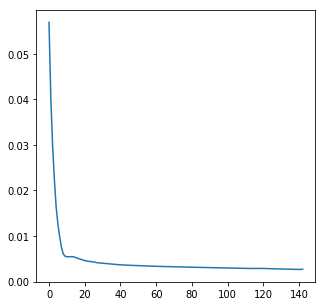

In [297]:
plt.plot(losses)

In [298]:
denoised = model(net_input).detach()

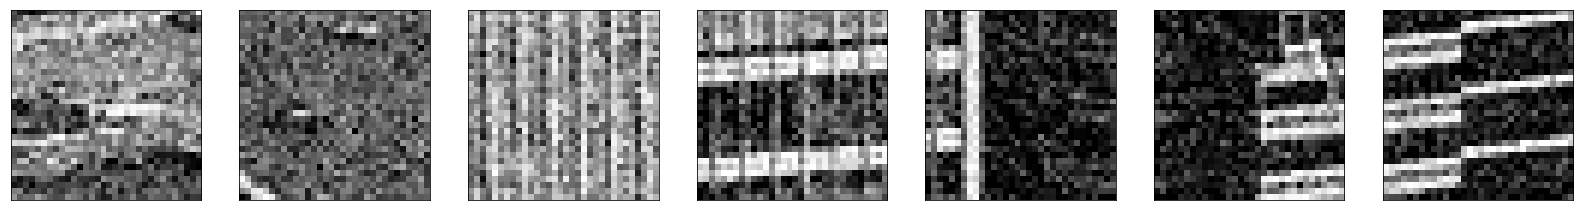

In [299]:
plot_tensors(noisy[::9])

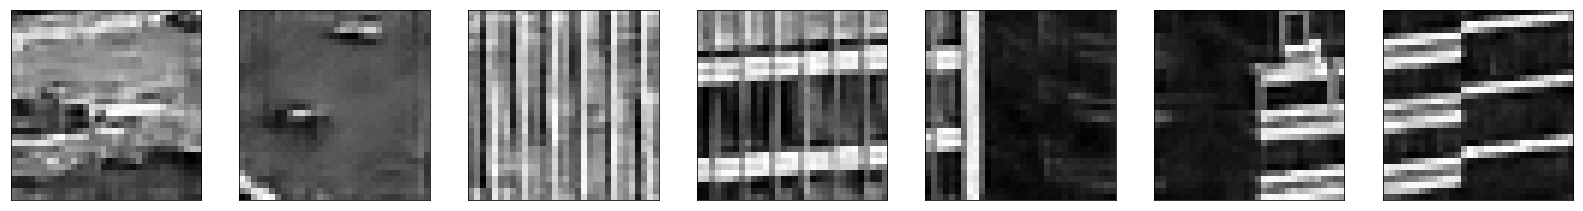

In [300]:
plot_tensors(denoised[::9])

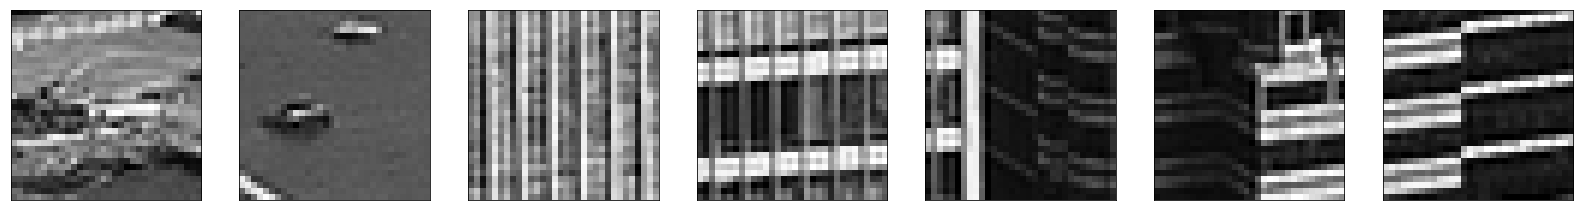

In [301]:
plot_tensors(clean[::9])

In [82]:
torch.nn.Fold()

In [79]:
model.dncnn(net_input).shape

torch.Size([64, 49, 32, 32])

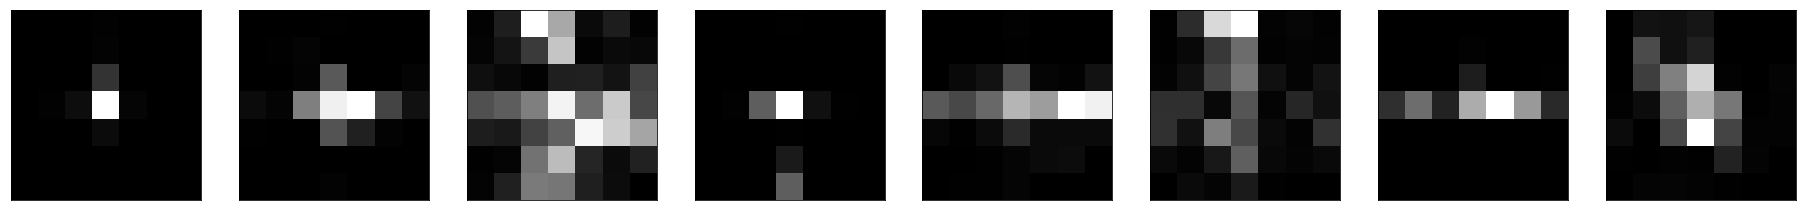

In [80]:
k = 2
kernel_width = 7
shape = [1, 1, kernel_width, kernel_width]

plot_tensors(
            torch.softmax(model.dncnn(net_input), 1)[:, :, 16, 12]
                 .reshape([net_input.shape[0], 1, kernel_width, kernel_width])[::9]
)

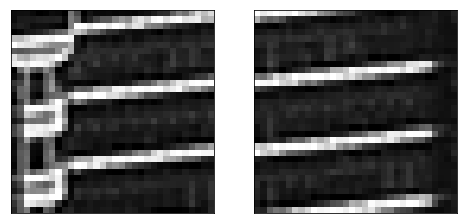

In [63]:
plot_tensors(clean[9*4:9*4+2])